# 轮廓计数

In [1]:
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import numpy as np

def plt_show(img_ndarray, figsize=(24,6), gray=True):
    plt.figure(figsize=figsize)
    plt.grid(False)
    if gray:
        plt.imshow(img_ndarray, 'gray')
    else:
        plt.imshow(img_ndarray)
    plt.show()


## 图像二值化
用于轮廓查找

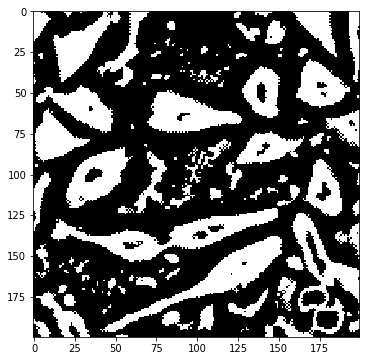

In [2]:
img_source = cv2.imread('imgs/cell.jpg')
img_gray = img_source[:, :, 1]
img_thresh = cv2.adaptiveThreshold( 
    img_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 25, 5)
plt_show(img_thresh)

## 查找图像轮廓
后续图像处理的基础操作

In [3]:
contours, hierarchy = cv2.findContours(img_thresh, 
                                       cv2.RETR_EXTERNAL,
                                       cv2.CHAIN_APPROX_NONE)

## 确定细胞核位置

In [4]:
def affirm_kernels_erode(contours, img_source, area_thresh=100, devision=1):
    """用img_bin作为辅助图 通过腐蚀处理img_bin上绘制的轮廓填充图进一步分离细胞核的轮廓
        判断标准：轮廓面积
        主要方法：腐蚀操作
        执行逻辑：
            1）首先选出面积大于200的轮廓 画到img_bin上
            2）循环腐蚀img_bin 每次保留面积大于100的轮廓
    
    para:
        contours:cv.findContour
        img_source:cv img : 要切分的原图；这里用来生成img_bin
        area_thresh:int: 认定是细胞核的最小面积值, 即小于这个值的一定不是细胞
        devision:int: 腐蚀操作的次数，0 表示不进行腐蚀操作
    ret:
        kernel_contours:cv.contour: 腐蚀分离后的轮廓图
        erosion:cv img: 腐蚀后的 img_bin
    note:
        腐蚀操作一定程度可以分离临近的细胞核轮廓，但也会消蚀原来较小的
        细胞核轮廓
    """
    # 1 img_bin 画板
    h, w, _ = img_source.shape
    img_bin = np.zeros((h, w))
    # 2 初步过滤轮廓
    good_kernel = []
    for i in range(len(contours)):
        if cv2.contourArea(contours[i]) > 200:  # 过滤掉面积较小的轮廓
            good_kernel.append(contours[i])
            # 2.1 先把较好的轮廓画到二值图上
            cv2.drawContours(img_bin, [contours[i]], -1, (255, 255, 255), cv2.FILLED)
    # plt_show(img_bin.astype(np.uint8), gray=True)

    # 2.2 保存初步过滤后的轮廓信息
    good_kernel_num = len(good_kernel)
    kernel_contours = good_kernel 
    # 3 通过腐蚀操作分离相邻的细胞核轮廓
    kernel = np.ones((2, 2), np.uint8)
    for iter in range(devision):
        print("erode...")
        # 3.1 腐蚀处理img_bin 后 再画轮廓  
        erode = cv2.erode(img_bin, kernel, iterations=1)
        cnts, h = cv2.findContours(
           erode.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        
        # 3.2 保存当前处理的轮廓信息
        cell_num = 0
        good_contours = []
        for cnt in cnts:  # 有一堆细胞
            if cv2.contourArea(cnt) > area_thresh:  # 腐蚀之后还大于100，认定细胞核的最小面积
                cell_num += 1  # 数一数 有多少个 面积大于 area_thresh的轮廓
                good_contours.append(cnt)  # 面积大于area_thresh的轮廓是好的
                
        if cell_num == good_kernel_num:
            print('第{}次腐蚀，核轮廓数量没有变化'.format(iter+1))
        # 3.3 更新轮廓信息   
        elif cell_num > good_kernel_num:  #  如果腐蚀过程中 腐蚀开了一些轮廓，原来的一个变成两个了
            print('新增轮廓')
            good_kernel_num = cell_num
            kernel_contours = good_contours 
            
        elif cell_num < good_kernel_num:
            print('第{}次腐蚀，减少了原来面积大于{}的轮廓'.format(iter+1, area_thresh))
            good_kernel_num = cell_num
            kernel_contours = good_contours
        # 4 迭代腐蚀
        img_bin = erode

    return kernel_contours, img_bin

erode...
第1次腐蚀，核轮廓数量没有变化


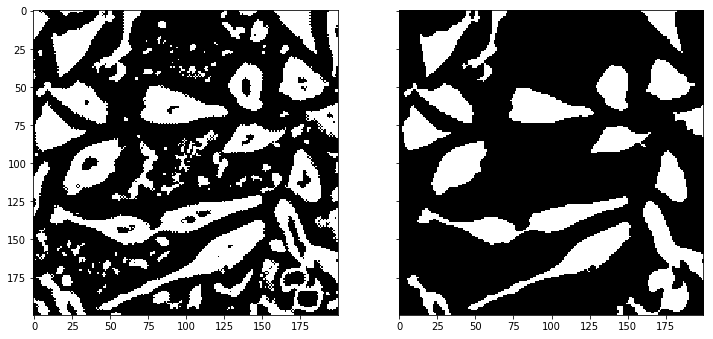

In [5]:
kernel_contours, img_bin = affirm_kernels_erode(contours, img_source)

f,ax = plt.subplots(1, 2,figsize=(12,6), sharey=True)
ax[0].imshow(img_thresh, 'gray')
ax[1].imshow(img_bin, 'gray')

## 细胞核计数

In [6]:
def cell_count(contours, img_source, erode_times=2):

    kernel_contours, erosion = affirm_kernels_erode(contours,
                                                    img_source,
                                                    devision=erode_times)

    for i, cnt in enumerate(kernel_contours):
        M = cv2.moments(cnt)
        try:
            cx = int(M['m10'] / M['m00'])
            cy = int(M['m01'] / M['m00'])
            cv2.circle(img_source, (cx, cy), 6, (255, 0, 0), 2)
            cv2.putText(img_source, str(i + 1), (cx + 5, cy + 5),
                        cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.8, (0, 255, 255), 1)
        except:
            continue
    plt_show(img_source)
    plt_show(erosion, gray=True)
    print('细胞个数为%d' % len(kernel_contours))

erode...
第1次腐蚀，核轮廓数量没有变化
erode...
新增轮廓


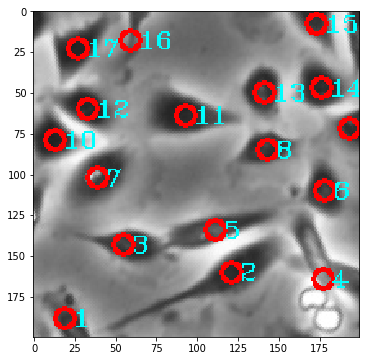

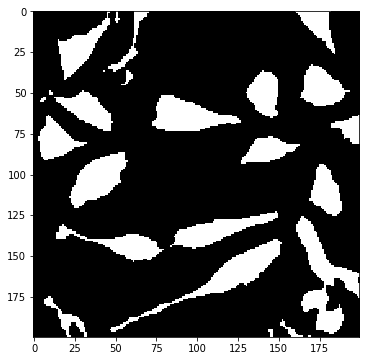

细胞个数为17


In [7]:
img_source = cv2.imread('imgs/cell.jpg')
cell_count(contours, img_source, erode_times=2)